Task: Write a PySpark program to find the employees total working hours during weekends.

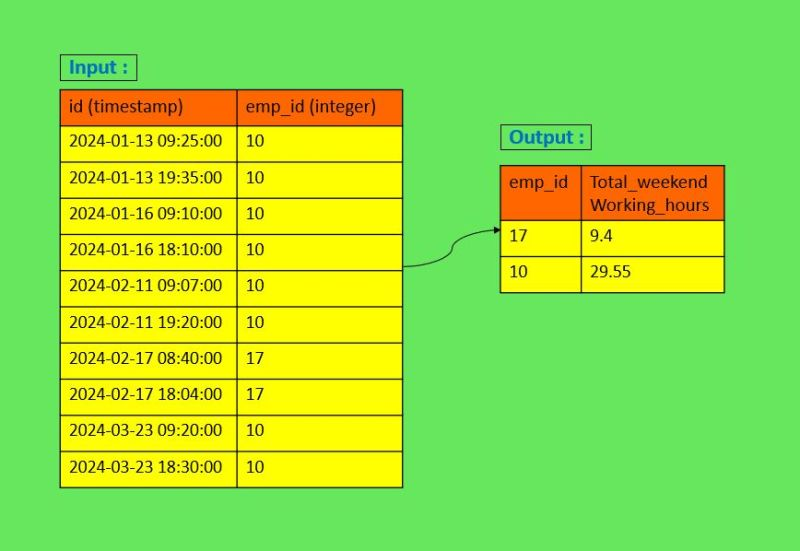

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('challenges').getOrCreate()

In [5]:
data=[('2024-01-13 09:25:00',10),('2024-01-13 19:35:00',10),('2024-01-16 09:10:00',10),('2024-01-16 18:10:00',10),('2024-02-11 09:07:00',10),('2024-02-11 19:20:00',10),('2024-02-17 08:40:00',17),('2024-02-17 18:04:00',17),('2024-03-23 09:20:00',10),('2024-03-23 18:30:00',10)]

schema='timestamp_string STRING, emp_id INT'

input_df = spark.createDataFrame(data,schema)
input_df.show()

+-------------------+------+
|   timestamp_string|emp_id|
+-------------------+------+
|2024-01-13 09:25:00|    10|
|2024-01-13 19:35:00|    10|
|2024-01-16 09:10:00|    10|
|2024-01-16 18:10:00|    10|
|2024-02-11 09:07:00|    10|
|2024-02-11 19:20:00|    10|
|2024-02-17 08:40:00|    17|
|2024-02-17 18:04:00|    17|
|2024-03-23 09:20:00|    10|
|2024-03-23 18:30:00|    10|
+-------------------+------+



In [6]:
import pyspark.sql.functions as F

# Add a new column that contains the day of the week
input_df = input_df.withColumn('day_of_week', F.dayofweek('timestamp_string'))
input_df.show()

+-------------------+------+-----------+
|   timestamp_string|emp_id|day_of_week|
+-------------------+------+-----------+
|2024-01-13 09:25:00|    10|          7|
|2024-01-13 19:35:00|    10|          7|
|2024-01-16 09:10:00|    10|          3|
|2024-01-16 18:10:00|    10|          3|
|2024-02-11 09:07:00|    10|          1|
|2024-02-11 19:20:00|    10|          1|
|2024-02-17 08:40:00|    17|          7|
|2024-02-17 18:04:00|    17|          7|
|2024-03-23 09:20:00|    10|          7|
|2024-03-23 18:30:00|    10|          7|
+-------------------+------+-----------+



In [56]:
# Filter the DataFrame to only include rows where the day of the week is Saturday or Sunday
df_weekends =  input_df.filter((F.col('day_of_week')== 7) | (F.col('day_of_week')==1))

# Introduce the date from the timestamp column
df_weekends = df_weekends.withColumn('date_str',F.to_date('timestamp_string'))

df_weekends.show()

+-------------------+------+-----------+----------+
|   timestamp_string|emp_id|day_of_week|  date_str|
+-------------------+------+-----------+----------+
|2024-01-13 09:25:00|    10|          7|2024-01-13|
|2024-01-13 19:35:00|    10|          7|2024-01-13|
|2024-02-11 09:07:00|    10|          1|2024-02-11|
|2024-02-11 19:20:00|    10|          1|2024-02-11|
|2024-02-17 08:40:00|    17|          7|2024-02-17|
|2024-02-17 18:04:00|    17|          7|2024-02-17|
|2024-03-23 09:20:00|    10|          7|2024-03-23|
|2024-03-23 18:30:00|    10|          7|2024-03-23|
+-------------------+------+-----------+----------+



In [45]:
# from pyspark.sql.window import Window

# window_spec = Window.partitionBy('emp_id','date_str')

# df_weekends = df_weekends.withColumn('max_time',max('timestamp_string').over(window_spec))
# df_weekends = df_weekends.withColumn('min_time',min('timestamp_string').over(window_spec))

# # Assuming you have two timestamp columns named 'timestamp1' and 'timestamp2'
# hours_difference = (F.unix_timestamp('max_time') - F.unix_timestamp('min_time')) / 3600

# df_agg = df_weekends.withColumn('difference',hours_difference)
# df_agg.show()


+-------------------+------+-----------+----------+-------------------+-------------------+------------------+
|   timestamp_string|emp_id|day_of_week|  date_str|           max_time|           min_time|        difference|
+-------------------+------+-----------+----------+-------------------+-------------------+------------------+
|2024-01-13 09:25:00|    10|          7|2024-01-13|2024-01-13 19:35:00|2024-01-13 09:25:00|10.166666666666666|
|2024-01-13 19:35:00|    10|          7|2024-01-13|2024-01-13 19:35:00|2024-01-13 09:25:00|10.166666666666666|
|2024-03-23 09:20:00|    10|          7|2024-03-23|2024-03-23 18:30:00|2024-03-23 09:20:00| 9.166666666666666|
|2024-03-23 18:30:00|    10|          7|2024-03-23|2024-03-23 18:30:00|2024-03-23 09:20:00| 9.166666666666666|
|2024-02-17 08:40:00|    17|          7|2024-02-17|2024-02-17 18:04:00|2024-02-17 08:40:00|               9.4|
|2024-02-17 18:04:00|    17|          7|2024-02-17|2024-02-17 18:04:00|2024-02-17 08:40:00|               9.4|
+

In [57]:
df_agg = df_weekends.groupBy('emp_id','date_str')\
    .agg(
            (F.unix_timestamp(max('timestamp_string'))-F.unix_timestamp(min('timestamp_string'))).alias('time_difference')
        )

df_agg = df_agg.withColumn('time_difference_hours',col('time_difference')/lit(3600))

df_agg.show()

+------+----------+---------------+---------------------+
|emp_id|  date_str|time_difference|time_difference_hours|
+------+----------+---------------+---------------------+
|    10|2024-01-13|          36600|   10.166666666666666|
|    10|2024-02-11|          36780|   10.216666666666667|
|    10|2024-03-23|          33000|    9.166666666666666|
|    17|2024-02-17|          33840|                  9.4|
+------+----------+---------------+---------------------+



In [66]:
df_agg = df_agg.groupBy('emp_id').agg(
                                sum('time_difference_hours').alias('Total_weekend_working_hours')
                            )

df_result = df_agg.withColumn('Total_weekend_working_hours', F.round('Total_weekend_working_hours', 2))

df_result.show()

+------+---------------------------+
|emp_id|Total_weekend_working_hours|
+------+---------------------------+
|    17|                        9.4|
|    10|                      29.55|
+------+---------------------------+

